In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import random
from openslide import open_slide
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from skimage.transform import resize
import matplotlib.colors as colors

In [2]:
Image.MAX_IMAGE_PIXELS = None

### Data functions

In [3]:
class Patch:
    '''
    Store properties of each patch
    '''

    def __init__(self, image, position, size=256):
        self.image = image
        self.position = position
        self.size = size
        self.probability = None
        self.prediction = None
        self.is_background = False
    
    def set_probability(self, probability):
        self.probability = probability

    def get_prediction(self):
        self.prediction = 1 if self.probability >= 0.5 else 0

### Helper functions

In [ ]:
def load_trained_model(num_classes, model_path): 

    model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    # INCEPTION
    # # Define model architecture
    # model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
    # # Replace last layers with new layers
    # num_ftrs = model.fc.in_features
    # model.fc = nn.Sequential(
    #     nn.Linear(num_ftrs, 2048),
    #     nn.ReLU(inplace=True),
    #     nn.Dropout(p=0.7),
    #     nn.Linear(2048, num_classes),
    #     nn.Softmax(dim=1)
    # )

    # Load the saved model state dict
    model.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode
    model.eval()

    return model

def scale_tensor(tensor: torch.Tensor):
    '''
    Scale a tensor to the range [0, 1]
    '''
    minn = tensor.min()
    maxx = tensor.max()
    tensor = (tensor - minn)/(maxx - minn)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def image_to_patches_with_positions(image, patch_size: int, stride: int):
    '''
    Function for splitting an input image into patches.

    Parameters:
    image: input image to split
    patch_size (int): dimension, patches will be square
    stride (int): controls overlap between patches

    Returns:
    Tensor of patches with shape (num_patches, im_dim (if applicable), patch_size, patch_size) with their positions in the original image
    '''
    # Convert image to PyTorch tensor
    im = torch.from_numpy(image)
    # Scale image to [0, 1]
    im = scale_tensor(im)

    # Is image colour or binary?
    image_dimension = 3 if len(image.shape) == 3 else 1
    # Working with a colour image
    if image_dimension == 3:
        # Extract patches
        patches = im.unfold(0, patch_size, stride).unfold(1, patch_size, stride)
        # Reshape tensor into tensor of shape (num_patches, 3, patch_size, patch_size)
        patches = patches.contiguous().view(-1, image_dimension, patch_size, patch_size) ###.contiguous() ensure tensor is stored in contiguous block of memory which is required for .view()
    # Working with greyscale image
    else:
        # Extract patches
        patches = im.unfold(0, patch_size, stride).unfold(1, patch_size, stride)
        # Reshape tensor into tensor of shape (num_patches, patch_size, patch_size)
        patches = patches.contiguous().view(-1, patch_size, patch_size)

    # Calculate the number of patches in each dimension
    height, width = image.shape[:2]
    num_patches_h = (height - patch_size) // stride + 1
    num_patches_w = (width - patch_size) // stride + 1

    # Generate positions of the patches
    positions = []
    for h in range(num_patches_h):
        for w in range(num_patches_w):
            # Calculate the top-left position of the current patch
            top = h * stride
            left = w * stride
            positions.append((top, left))

    return patches, positions

def get_patch_objects(patches, positions):
    patch_objects = []
    for patch, position in zip(patches, positions):
        patch_object = Patch(image=patch, position=position)
        patch_objects.append(patch_object)
    return patch_objects

## CHECK THIS FUNCTION PROPERLY for my data
def check_if_background(patch):
    '''
    Given a patch, return whether it should be classified as a background patch or not.
    '''
    # working with actual patch now and NOT the mask?????????????????
    im = np.array(patch) * 255
    pixels = np.ravel(im)
    mean = np.mean(pixels)
    is_background = mean >= 220
    return is_background

def choose_random_image(directory, seed):
    '''
    Choose a SVS file randomly to perform inference and produce heatmap.

    Return level 1 image from SVS file as well as the images case code.
    '''
    random.seed(seed)
    files = os.listdir(directory)
    svs_files = [file for file in files if file.endswith(('.svs'))]
    # Randomly choose file
    random_svs = random.choice(svs_files)
    print(random_svs)
    name = random_svs.replace('.svs', '')
    if name.startswith('._'):
        name = name.replace('._', '')
    case_code = name.split('.')[0].replace('TCGA-', '').replace('-01Z-00-DX1', '')
    slide_path = os.path.join(directory, random_svs)
    sld = open_slide(slide_path)
    slide_props = sld.properties
    slide_width = int(slide_props['openslide.level[1].width']); slide_height = int(slide_props['openslide.level[1].height']) # dimensions at 10X magnification
    slide = np.array(sld.get_thumbnail(size=(slide_width, slide_height)))

    return case_code, slide

# def check_seg_accuracy(label_directory, case_code):
#     # get image labels for 
#     # going to run into problem: what if there arent the same number of background patches as this algorithm returns - wont be able to calculate accuracy
#     return acc

def get_prediction(patch, output):
    # preprocess

    # get predictions for patch
    probabilities = torch.softmax(output, dim=1) # Post-process the predictions
    patch.probability = probabilities[0][1].item()
    predicted_class = torch.argmax(probabilities, dim=1).item()
    patch.prediction = predicted_class

def create_heatmaps(image_size, patches):
    '''
    Generate heatmap arrays based on patch predictions.
    Returns 2D heatmaps the same size as original image.

    Return: heatmap containing probabilities, and heatmap containing predicted classes (None, 0, 1)
    '''
    heatmap_probabilities = np.full(image_size, -1, dtype=np.float64)
    heatmap_classes = np.full(image_size, None)
    for patch in patches:
        i, j = patch.position
        h, w = patch.image.size()[1], patch.image.size()[2]
        heatmap_probabilities[i:i+h, j:j+w] = patch.probability
        heatmap_classes[i:i+h, j:j+w] = patch.prediction
    
    return heatmap_probabilities, heatmap_classes

def inference(image_size, patches, model):
    '''
    Takes in Patch objects and makes predictions for each patch if it is not classified as a background patch.
    Then uses those predictions to create a heatmap - returns heatmap that contains class probabilites, and None for background patches.
    '''
    for patch in patches:
        image = patch.image
        is_background = check_if_background(image)
        if not is_background:
            model.eval()
            with torch.no_grad():
                output = model(image.unsqueeze(0))
            get_prediction(patch, output)
        else:
            patch.probability = -1
            patch.prediction = None
    heatmap_probs, heatmap_classes = create_heatmaps(image_size, patches)
    return heatmap_probs, heatmap_classes

def visualise_heatmap(heatmap, title):
    '''
    Resize the heatmap for visualisation purposes and display it.
    '''
    new_width = 5000
    original_width, original_height = heatmap.shape
    new_height = int(new_width * (original_width / original_height))
    thumbnail = resize(heatmap.astype(float), (new_height, new_width))
    plt.imshow(thumbnail, cmap="gray")
    plt.title(title)
    plt.axis('off')

def visualise_classification_map(heatmap):
    '''
    Create visual of predicted classes. 
    (Given as None, 0, 1 - for display purposes needs to be 0, 0.5, 1)
    '''
    output = np.full(heatmap.shape, None)
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            if heatmap[i, j] == None:
                output[i, j] = 0 # background
            elif heatmap[i, j] == 0:
                output[i, j] = 0.5 # normal tissue
            elif heatmap[i, j] == 1:
                output[i, j] = 1 # malignant tissue
            else:
                raise Exception("Heatmap of predicted classes contains values other than None, 0 or 1")
    visualise_heatmap(output, "Predicted class labels")

def visualise_probabilities_map(heatmap_probs):
    values = heatmap_probs.copy()
    values = np.where(values == -1, np.nan, values)

    plt.imshow(values, cmap='plasma', vmin=0, vmax=1)
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Benign', 'Malignant'])
    plt.title("Predicted tumour probabilities")
    plt.axis('off')

def visualise_heatmap_over_image(slide, image, heatmap_probabilities):
    '''
    Returns heatmap overlaid on original image.
    '''
    image_size = image.shape[0:2]
    # Create mask for probabilities
    mask = heatmap_probabilities < 0.1
    heatmap = heatmap_probabilities.copy()
    heatmap[mask] = np.nan

    # display purposes
    new_width = 5000
    original_width, original_height = image_size
    new_height = int(new_width * (original_width / original_height))
    slide_thumbnail = np.array(slide.get_thumbnail(size=(new_width, new_height)))
    thumbnail = resize(heatmap.astype(float), (new_height, new_width))
    fig=plt.figure()
    ax = plt.axes()
    im = ax.imshow(slide_thumbnail)
    im = ax.imshow(thumbnail, cmap='plasma', vmin=0, vmax=1)
    plt.axis('off')
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    plt.show()


In [5]:
PATCH_SIZE=256
STRIDE=PATCH_SIZE
num_classes=2
SEED=42

In [ ]:
images_directory = '/Volumes/AlexS/MastersData/SVS files/'
labels_directory = '/Volumes/AlexS/MastersData/processed/labels/'

### Main

In [ ]:
# load image
image = choose_random_image(images_directory, SEED)
image_size = image.shape
# extract patches
patches, positions = image_to_patches_with_positions(image, PATCH_SIZE, STRIDE)
# create Patch objects
patch_objects = get_patch_objects(patches, positions)
# Get trained model
model_path = '../models/splendid-dawn-22_model_weights.pth'
model = load_trained_model(num_classes, model_path)
heatmap = inference(image_size, patch_objects, model)

### Notes

- Want to be able to overlay this produced heatmap over the original slide
- Also need to create heatmap of the original slide with its classes to visualise what is the ground truth segmentation using patches
- when using the inception model, remember to apply the preprocessing steps to the image before making predictions

### Testing functions

In [6]:
slide_path = '/Users/alexandrasmith/Desktop/TCGA-A2-A0SY-01Z-00-DX1.279A5479-E183-4F79-AF40-50BF1834BA4A.svs'
# name = 'TCGA-A2-A0CX-01Z-00-DX1.F07C75AB-E568-45CB-B497-37C712490393.svs'
name = slide_path.replace('/Users/alexandrasmith/Desktop/', '')
case_code = name.split('.')[0].replace('TCGA-', '').replace('-01Z-00-DX1', '')
print(case_code)
sld = open_slide(slide_path)
slide_props = sld.properties
slide_width = int(slide_props['openslide.level[1].width']); slide_height = int(slide_props['openslide.level[1].height']) # dimensions at 10X magnification
slide = np.array(sld.get_thumbnail(size=(slide_width, slide_height)))

A2-A0SY


Issues to consider:
- I deleted a bunch of patches (black/grey spots, etc) which will cause issues since they won't be detected as white/background so the model will make bad predictions on them!!

In [7]:
patches, positions = image_to_patches_with_positions(slide, PATCH_SIZE, STRIDE)

In [8]:
patch_objects = get_patch_objects(patches, positions)

In [9]:
# Get trained model
model_path = '../models/splendid-dawn-22_model_weights.pth'
model = load_trained_model(num_classes, model_path)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model = model.to(device)

In [10]:
image_size = slide.shape

In [51]:
heatmap_probs, heatmap_classes = inference(image_size[0:2], patch_objects, model)

In [ ]:
visualise_probabilities_map(heatmap_probs)

In [ ]:
visualise_classification_map(heatmap_classes)

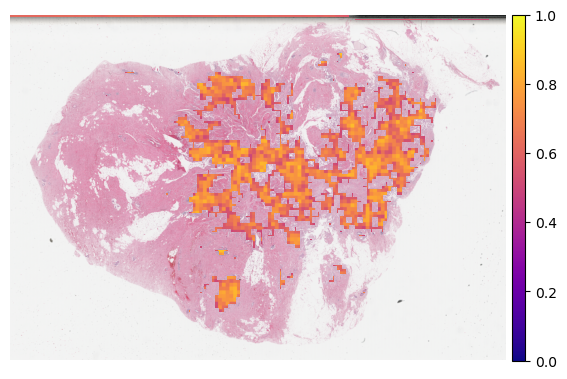

In [ ]:
visualise_heatmap_over_image(sld, slide, heatmap_probs)

In [ ]:
# Test one patch and its prediction
ex_patch = patch_objects[4010]
p1 = ex_patch.image
pred = ex_patch.prediction

plt.imshow(np.transpose(p1.numpy(), (1, 2, 0)))
plt.title(f"Predicted class: {pred}")
plt.axis('off')

In [ ]:
# Plot a few examples
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()
for ax in axes:
    patch = random.choice(patch_objects)
    image = patch.image
    pred = patch.prediction
    # pred = 'background' if pred == None else str(pred)
    title = f"Predicted class: {pred}" if pred != None else "background"
    ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()